In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from interaction_effects.marginal import MarginalExplainer
from interaction_effects import utils

In [3]:
n = 3000
d = 3
batch_size = 50
learning_rate = 0.02

In [4]:
X = np.random.randn(n, d)
y = (np.sum(X, axis=-1) > 0.0).astype(np.float32)

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(3,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(2, activation=None, use_bias=True))

In [6]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [7]:
model.fit(X, y, epochs=20, verbose=2)

Train on 3000 samples
Epoch 1/20
3000/3000 - 1s - loss: 3.7362 - sparse_categorical_accuracy: 0.6037
Epoch 2/20
3000/3000 - 0s - loss: 0.4334 - sparse_categorical_accuracy: 0.9277
Epoch 3/20
3000/3000 - 0s - loss: 0.4227 - sparse_categorical_accuracy: 0.9347
Epoch 4/20
3000/3000 - 0s - loss: 0.4213 - sparse_categorical_accuracy: 0.9343
Epoch 5/20
3000/3000 - 0s - loss: 0.4208 - sparse_categorical_accuracy: 0.9340
Epoch 6/20
3000/3000 - 0s - loss: 0.4205 - sparse_categorical_accuracy: 0.9343
Epoch 7/20
3000/3000 - 0s - loss: 0.4204 - sparse_categorical_accuracy: 0.9347
Epoch 8/20
3000/3000 - 0s - loss: 0.4204 - sparse_categorical_accuracy: 0.9343
Epoch 9/20
3000/3000 - 0s - loss: 0.4204 - sparse_categorical_accuracy: 0.9350
Epoch 10/20
3000/3000 - 0s - loss: 0.4203 - sparse_categorical_accuracy: 0.9347
Epoch 11/20
3000/3000 - 0s - loss: 0.4203 - sparse_categorical_accuracy: 0.9350
Epoch 12/20
3000/3000 - 0s - loss: 0.4203 - sparse_categorical_accuracy: 0.9350
Epoch 13/20
3000/3000 - 0s 

In [16]:
primal_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:20], verbose=True, index_outputs=True, labels=y[:20].astype(int))

100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


In [17]:
dual_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:20], verbose=True, index_outputs=True, labels=y[:20].astype(int))

100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


In [18]:
average_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:20], verbose=True, index_outputs=True, labels=y[:20].astype(int))

100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


In [19]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:20])
kernel_shap = np.stack(kernel_shap, axis=0)

In [20]:
kernel_shap_true_class = kernel_shap[y[:20].astype(int), np.arange(20), :]

In [50]:
def unroll(x):
    ret = []
    for i in range(x.shape[-1]):
        ret.append(x[:, i])
    return np.concatenate(ret)

In [55]:
data_df = pd.DataFrame({
    'Sampled Primal Effects':  unroll(primal_effects),
    'Sampled Dual Effects':    unroll(dual_effects),
    'Sampled Average Effects': unroll(average_effects),
    'Kernel SHAP Values':      unroll(kernel_shap_true_class),
    'Feature Values':          unroll(X[:20]),
    'Feature':                 [int(i / 20) for i in range(20 * d)],
    'Label':                   np.tile(y[:20], 3).astype(int)
})

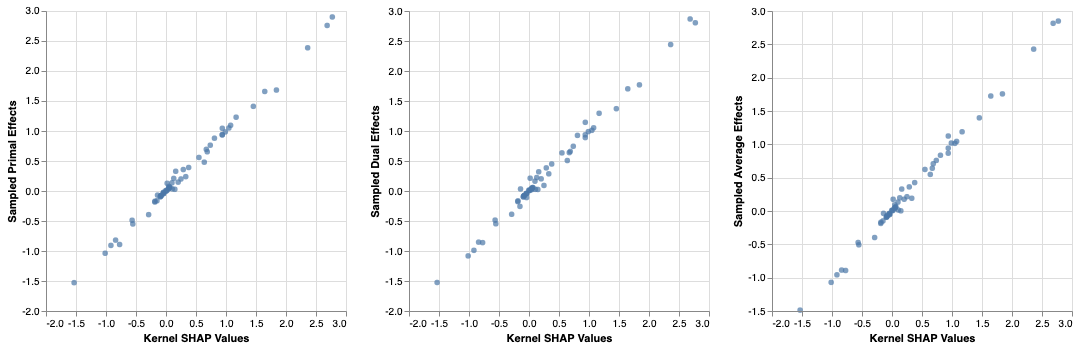

In [56]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('Kernel SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative')
).properties(width=300, height=300).repeat(column=['Sampled Primal Effects', 'Sampled Dual Effects', 'Sampled Average Effects'])

In [64]:
melted_df = pd.melt(data_df, id_vars=['Feature Values', 'Feature', 'Label'], var_name='Effect Type', value_name='Effect Value')

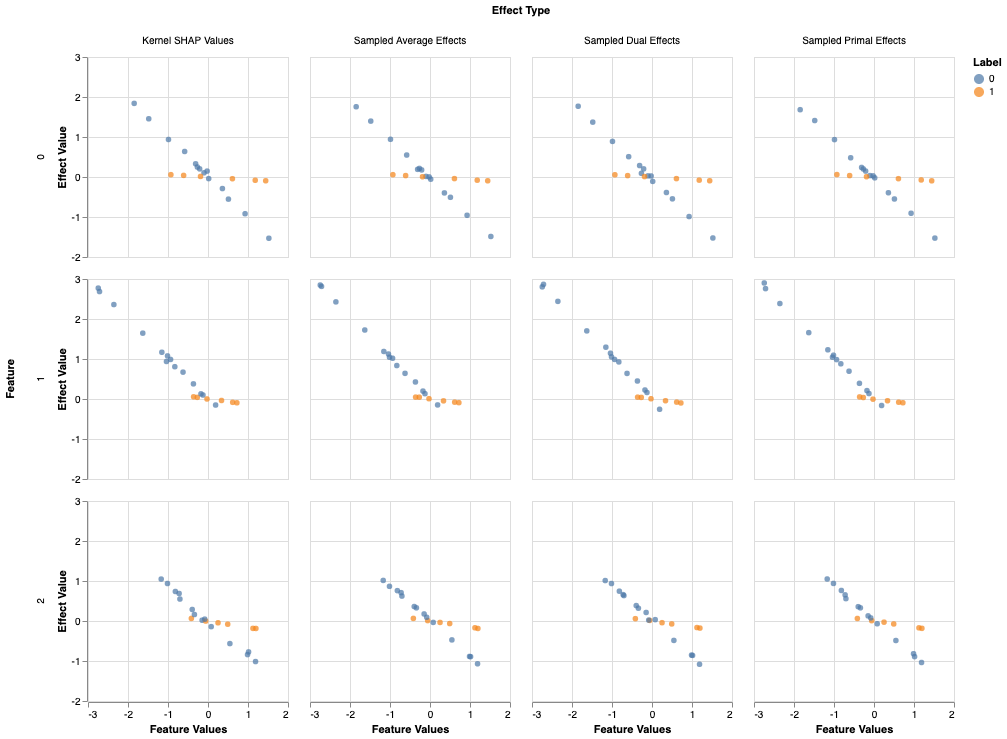

In [68]:
alt.Chart(melted_df).mark_point(filled=True).encode(
    alt.X('Feature Values:Q'),
    alt.Y('Effect Value:Q'),
    alt.Color('Label:N')
).properties(width=200, height=200).facet(column='Effect Type', row='Feature')